In [1]:
import time

# Keep track of run time
start_time = time.time()

# ********* Start ************
# This section is to ensure to get the right directory when submitting a job
import sys
import os
current_dir = os.path.abspath('./')
parent_dir = os.path.abspath('./../')
sys.path.append(current_dir)
sys.path.append(parent_dir)

# Set the working directory to the directory containing the script
custom_path = current_dir

# Get the absolute path of the current script
script_dir = os.path.abspath(custom_path)

# ********* END ************

# ********* Start of main code *************
import DataLoader as DL
import SetTransformer_Extrapolating as ST
import ContrastiveModel as CM

#to plot data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
import random
from torch.optim.lr_scheduler import ExponentialLR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from itertools import islice
import numpy as np

# To track the total number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

folder_path = "../../../Data/3dbsf_txt/"

min_lines, max_lines = DL.get_min_max_lines(folder_path)
print(f"The minimum number of lines among all files: {min_lines}")
print(f"The maximum number of lines among all files: {max_lines}")

# Load data and corresponding targets
dataset, targets, _ = DL.load_dataset(folder_path, num_lines = min_lines)

# Get device to run on available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom data split 80:20
splitter = DL.DatasetSplitter(validation_ratio=0.2, shuffle = True)
train_data,train_targets, val_data, val_targets = splitter.split_dataset(dataset, targets)

# Custom collate function to subssample the point cloud data
def custom_collate(subsample_size):
    def collate_fn(batch):
        subsamples = []
        for data, target in batch:
            num_samples = data.shape[0]
            current_subsample_size = min(subsample_size, num_samples)
            indices = random.sample(range(num_samples), subsample_size)
            subsample = data[indices]
            subsamples.append((subsample, target))

        data, targets = zip(*subsamples)
        data = torch.stack(data, dim=0)
        targets = torch.stack(targets, dim=0)

        return data, targets
    
    return collate_fn


# Define the batch size, training subsample size and validation subsample size


/home/dsk2v/PointCloud/BodyScan/FourthDraftWithPartialMetaData/DataLoader/../../../Data/3dbsf_txt/
/home/dsk2v/PointCloud/Data/3dbsf_txt
The minimum number of lines among all files: 49493
The maximum number of lines among all files: 63914
/home/dsk2v/PointCloud/BodyScan/FourthDraftWithPartialMetaData/DataLoader/../../../Data/3dbsf_txt/
[38128 18320  7616 ...  1922 23905 29003]


/home/dsk2v/.conda/envs/my_miniconda_dsk2v_4/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
val_data.shape

(96, 9898, 3)

The digit is a 11


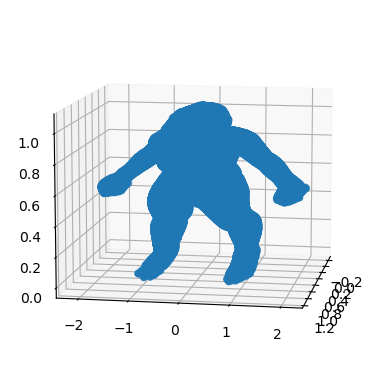

The digit is a 11


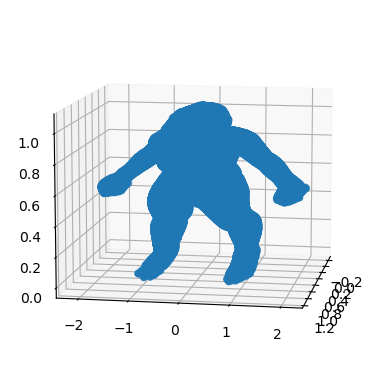

In [3]:
index = 3 # the index of the batch to show

print("The digit is a", targets[index])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*dataset[index].T, cmap='viridis')
ax.view_init(elev=10, azim=10)
plt.show()

print("The digit is a", targets[index])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*dataset[index].T, cmap='viridis')
ax.view_init(elev=10, azim=10)
plt.show()

In [4]:
batch_size = 32
subsample_size = 2048

# Load the batches using CustomDataLoader as to create more number of batches with replacement
train_subsampled_dataloader = DL.CustomDataLoader(train_data, train_targets, batch_size=batch_size, num_batches=100, subsample_size=subsample_size, shuffle=True,augmentation_by_cube=True, augment_rotation = True)
val_subsampled_dataloader = DL.CustomDataLoader(val_data, val_targets, batch_size=batch_size, num_batches=50, subsample_size=subsample_size, shuffle=True, augmentation_by_cube=True)

In [5]:
# train_subsampled_dataloader.__getitem__(0)

In [6]:
len(train_subsampled_dataloader[0])

2

In [7]:
t = train_subsampled_dataloader.__getitem__(0)

In [8]:
# small_cube_min = t[2]
# small_cube_max = t[3]
# # Define the vertices for the cube without diagonal lines
# vertices = [
#     [small_cube_min, (small_cube_max[0], small_cube_min[1], small_cube_min[2]),
#      (small_cube_max[0], small_cube_max[1], small_cube_min[2]), (small_cube_min[0], small_cube_max[1], small_cube_min[2])],
#     [small_cube_max, (small_cube_max[0], small_cube_min[1], small_cube_min[2]),
#      (small_cube_max[0], small_cube_min[1], small_cube_max[2]), small_cube_max],
#     [small_cube_min, (small_cube_max[0], small_cube_min[1], small_cube_min[2]),
#      (small_cube_max[0], small_cube_min[1], small_cube_max[2]), (small_cube_min[0], small_cube_min[1], small_cube_max[2])],
#     [small_cube_min, (small_cube_max[0], small_cube_min[1], small_cube_max[2]),
#      (small_cube_max[0], small_cube_max[1], small_cube_max[2]), (small_cube_min[0], small_cube_max[1], small_cube_max[2])],
#     [small_cube_min, (small_cube_max[0], small_cube_max[1], small_cube_min[2]),
#      (small_cube_max[0], small_cube_max[1], small_cube_max[2]), (small_cube_min[0], small_cube_max[1], small_cube_max[2])],
#     [small_cube_min, (small_cube_max[0], small_cube_min[1], small_cube_min[2]),
#      (small_cube_max[0], small_cube_min[1], small_cube_max[2]), (small_cube_min[0], small_cube_min[1], small_cube_max[2])]
# ]


In [9]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# index = 10 # the index of the batch to show

# print("The digit is a", train_targets[index])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# t1 = t[1]
# t4 = t[4]
# ax.scatter(t1[0], t1[1], t1[2], color='red',s=15.1)
# ax.scatter(*t4.T, cmap='viridis',s=0.1)
# # Create Poly3DCollection for the cube
# cube = Poly3DCollection(vertices, alpha=0.25, linewidths=1, edgecolors='orange')
# ax.add_collection3d(cube)

# ax.view_init(elev=0, azim=0)
# plt.show()

# print("The digit is a", val_targets[index])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # f = train_subsampled_dataloader[index][1][0]
# # print(f.shape)
# t0 = t[0]
# ax.scatter(*t0.T, cmap='viridis',s=0.1)
# ax.view_init(elev=0, azim=0)
# plt.show()

In [10]:
t = val_subsampled_dataloader.__getitem__(0)

The digit is a 72


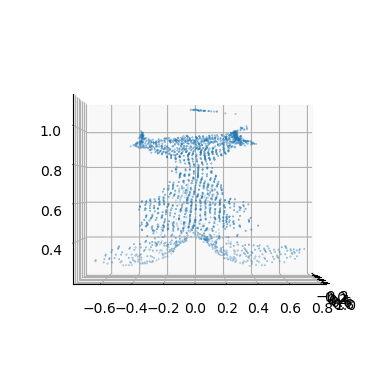

The digit is a 72


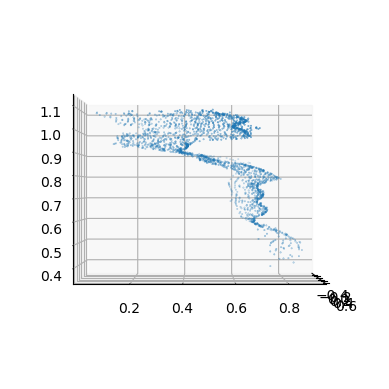

In [23]:
index = 1 # the index of the batch to show
train_subsampled_dataloader.epoch = 130
t = train_subsampled_dataloader[index]
print("The digit is a", train_targets[index])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t0 = t[0][0]
ax.scatter(*t0.T, cmap='viridis',s=0.1)
ax.view_init(elev=0, azim=0)
plt.show()

print("The digit is a", val_targets[index])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t1 = t[1][0]
ax.scatter(*t1.T, cmap='viridis',s=0.1)
ax.view_init(elev=0, azim=0)
plt.show()

In [24]:
train_subsampled_dataloader.rho


0.8999999999999999